In [ ]:
#!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_scoreedddddddddddddddddddddddddd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.dates import MonthLocator, DateFormatter
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Monografía/datos_arbei/Datos_monografía.xlsx')
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.set_index('date', inplace=True)

# Especificar la frecuencia mesual de la serie temporal
df = df.asfreq('MS')

Antes de entrenar el modelo debemos comprobar que los datos sean estacionarios para ello usamos con la prueba de Dickey-Fuller aumentada (ADF)

Hipótesis Nula (H0): La serie temporal tiene una raíz unitaria (no es estacionaria).
Hipótesis Alternativa (H1): La serie temporal no tiene una raíz unitaria (es estacionaria).

Si valor p < 0.05 rechazamos la hipótesis nula y nuestros datos son estacionarios

In [ ]:
# Verificar la estacionariedad con ADF
result = adfuller(df['ndvi'].dropna())
print('ADF Statistic:', result[0].round(2))
print('p-value:', result[1].round(2))

ADF Statistic: -1.83
p-value: 0.37


Dado que el valor p (0.367) es mayor que 0.05, no podemos rechazar la hipótesis nula de que la serie tiene una raíz unitaria, lo que indica que los datos no son estacionarios. Por lo tanto, es necesario realizar transformaciones para que los datos sean estacionarios antes de aplicar el modelo ARIMA.

Aplicamos Diferenciación Regular para eliminar tendencias lineales



In [ ]:
# Diferenciación regular
df['ndvi_diff'] = df['ndvi'].diff().dropna()
result_diff = adfuller(df['ndvi_diff'].dropna())
print('ADF Statistic after differencing:', result_diff[0].round(2))
print('p-value after differencing:', result_diff[1])

ADF Statistic after differencing: -9.09
p-value after differencing: 3.9585345408648235e-15


Aplicamos Diferenciación Estacional para eliminar patrones estacionales

In [ ]:
# Diferenciación estacional
seasonal_period = 3
df['ndvi_seasonal_diff'] = df['ndvi'].diff(periods=seasonal_period).dropna()
result_seasonal_diff = adfuller(df['ndvi_seasonal_diff'].dropna())
print('ADF Statistic after seasonal differencing:', result_seasonal_diff[0].round(2))
print('p-value after seasonal differencing:', result_seasonal_diff[1])

ADF Statistic after seasonal differencing: -8.14
p-value after seasonal differencing: 1.056813067715856e-12


Luego de realizar las diferenciaciones obtenemos valores p menores a 0.05 por lotanto, las transformaciones aplicadas han sido efectivas para hacer que la serie temporal sea estacionaria, lo que nos permite proceder con la aplicación del modelo ARIMA.


In [ ]:
# Estandarización de variables exógenas usando MinMaxScaler
variables = ['precipitation','soil_moisture', 'recharge']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[variables])
scaled_df = pd.DataFrame(scaled_features, index=df.index, columns=variables)
df[variables] = scaled_df

In [ ]:
df

,ndvi,precipitation,real_evapotranspiration,interception,potential_evapotranspiration,soil_moisture,recharge,ndvi_diff,ndvi_seasonal_diff
date,,,,,,,,,
2013-01-01,0.668057,0.000000,67.777152,6.616557,137.253919,0.434685,0.000103,NaN,NaN
2013-02-01,0.594504,0.271296,67.710569,20.110346,121.178929,0.313876,0.014731,-0.073553,NaN
2013-03-01,0.637496,0.308156,84.763105,25.720141,144.200782,0.385454,0.022327,0.042992,NaN
2013-04-01,0.651578,0.525013,109.409384,2.627605,139.970673,0.444698,0.118115,0.014082,-0.016479
2013-05-01,0.766817,0.896439,113.587322,3.724465,121.613561,0.811397,0.775615,0.115239,0.172313
...,...,...,...,...,...,...,...,...,...
2020-08-01,0.746717,0.505852,132.663656,26.843803,171.888381,0.648396,0.112395,-0.048624,0.016894
2020-09-01,0.776158,0.632025,126.817202,33.339521,147.678557,0.760405,0.294230,0.029441,0.006492
2020-10-01,0.782027,0.591605,142.040391,31.471432,167.062102,0.801600,0.182098,0.005869,-0.013314


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2013-01-01 to 2020-12-01
Freq: MS
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ndvi                          96 non-null     float64
 1   precipitation                 96 non-null     float64
 2   real_evapotranspiration       96 non-null     float64
 3   interception                  96 non-null     float64
 4   potential_evapotranspiration  96 non-null     float64
 5   soil_moisture                 96 non-null     float64
 6   recharge                      96 non-null     float64
 7   ndvi_diff                     95 non-null     float64
 8   ndvi_seasonal_diff            93 non-null     float64
dtypes: float64(9)
memory usage: 7.5 KB


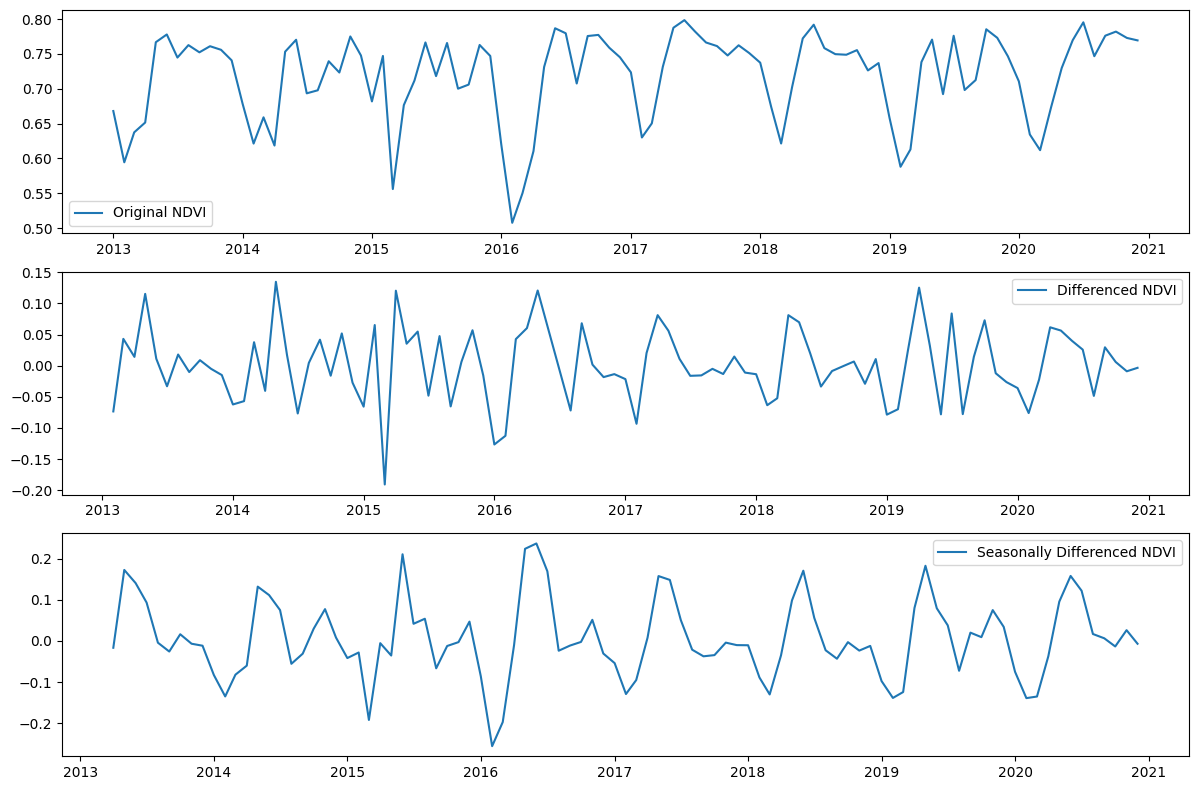

In [ ]:
# Graficar las transformaciones
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(df['ndvi'], label='Original NDVI')
plt.legend(loc='best')

plt.subplot(312)
plt.plot(df['ndvi_diff'], label='Differenced NDVI')
plt.legend(loc='best')

plt.subplot(313)
plt.plot(df['ndvi_seasonal_diff'], label='Seasonally Differenced NDVI')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

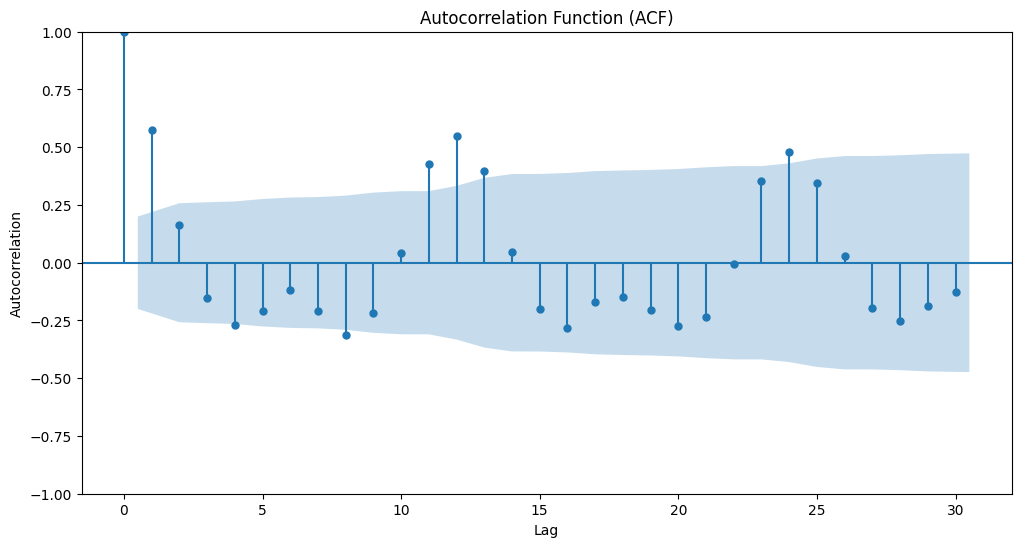

In [ ]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df['ndvi'], lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

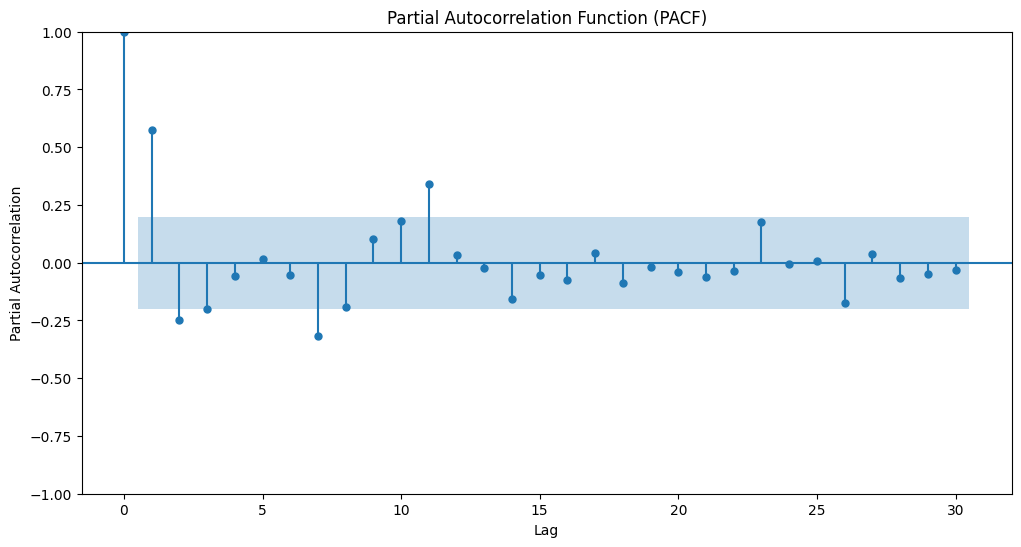

In [ ]:
# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df['ndvi'], lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
# Ajuste del modelo SARIMAX con las variables exógenas especificadas
exog_variables = df[variables].dropna()
common_index = df['ndvi_seasonal_diff'].dropna().index.intersection(exog_variables.index)

# División de la serie en datos de entrenamiento (80% de los datos)y de prueba (20% de los datos)
train_size = int(len(common_index) * 0.8)
train_idx, test_idx = common_index[:train_size], common_index[train_size:]

train = df['ndvi_seasonal_diff'].loc[train_idx]
test = df['ndvi_seasonal_diff'].loc[test_idx]
exog_train = exog_variables.loc[train_idx]
exog_test = exog_variables.loc[test_idx]

# Ajuste del modelo ARIMA usando auto_arima
auto_model = auto_arima(train, exogenous=exog_train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-138.976, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-154.515, Time=1.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-140.973, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-137.042, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-175.311, Time=1.24 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-177.344, Time=2.07 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=-175.347, Time=4.72 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=-173.503, Time=1.63 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=-178.037, Time=1.49 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-177.155, Time=0.64 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : 

In [ ]:
# Parámetros de auto arima
order = auto_model.order
seasonal_order = auto_model.seasonal_order

# Ajuste del modelo SARIMAX con los parámetros obtenidos de auto_arima
model = SARIMAX(train, order=order, seasonal_order=seasonal_order, exog=exog_train, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False, maxiter=500)

# Evaluar el modelo utilizando AIC
aic = model_fit.aic
print(f"AIC: {aic}")

AIC: -122.96216129507431


In [ ]:
# Predicciones con el modelo ajustado
y_pred = model_fit.forecast(steps=len(test), exog=exog_test)

# Evaluación del modelo
mse = mean_squared_error(test, y_pred)
mae = mean_absolute_error(test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(test, y_pred)

print("Mean Squared Error (MSE):", mse.round(4))
print("Mean Absolute Error (MAE):", mae.round(4))
print("Root Mean Squared Error (RMSE):", rmse.round(4))
print("R-squared (R2):", r2.round(4))

Mean Squared Error (MSE): 0.0019
Mean Absolute Error (MAE): 0.0363
Root Mean Squared Error (RMSE): 0.0432
R-squared (R2): 0.6848


Residuals:
count    74.000000
mean     -0.001200
std       0.065037
min      -0.188317
25%      -0.038397
50%       0.002769
75%       0.033049
max       0.159592
dtype: float64


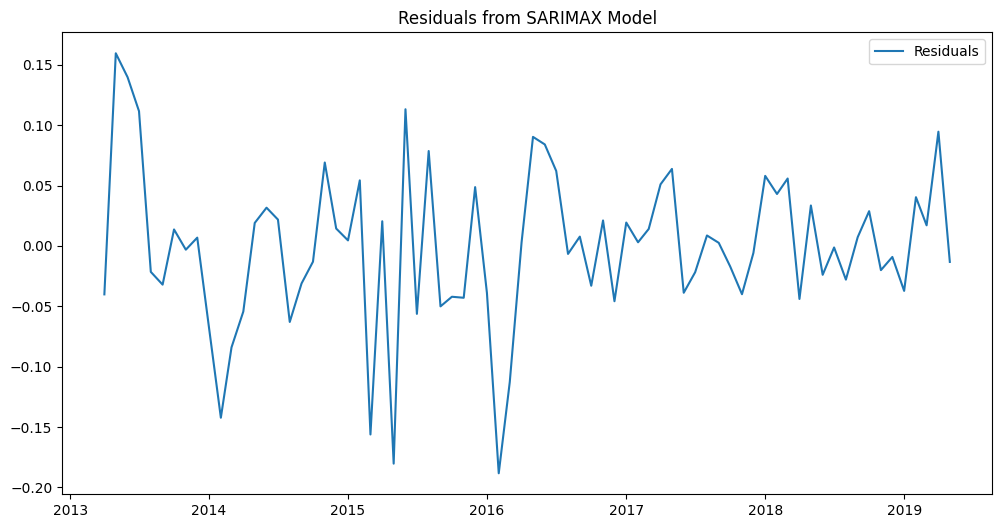

In [ ]:
# Verificación y visualización de residuos
residuals = model_fit.resid
print("Residuals:")
print(residuals.describe())

plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals from SARIMAX Model')
plt.legend()
plt.show()

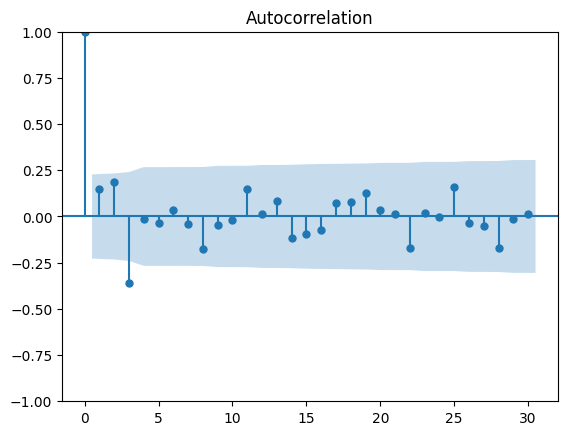

In [ ]:
# ACF de los residuos
plot_acf(residuals.dropna(), lags=30)
plt.show()

In [ ]:
# Prueba de Ljung-Box
lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print(lb_test)

if lb_test['lb_pvalue'].values[0] > 0.05:
    print("No hay suficiente evidencia para rechazar la hipótesis nula. Los residuos son independientes.")
else:
    print("Hay suficiente evidencia para rechazar la hipótesis nula. Los residuos no son independientes.")

      lb_stat  lb_pvalue
10  17.975699   0.055375
No hay suficiente evidencia para rechazar la hipótesis nula. Los residuos son independientes.


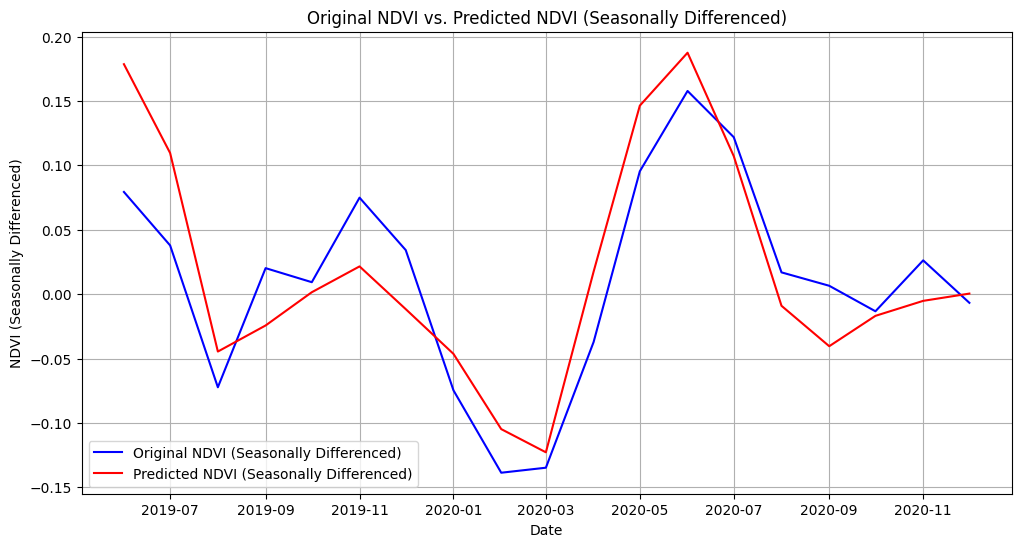

In [ ]:
# Gráfica de los valores originales y predichos de NDVI (diferenciados estacionalmente)
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Original NDVI (Seasonally Differenced)', color='blue')
plt.plot(test.index, y_pred, label='Predicted NDVI (Seasonally Differenced)', color='red')
plt.xlabel('Date')
plt.ylabel('NDVI (Seasonally Differenced)')
plt.title('Original NDVI vs. Predicted NDVI (Seasonally Differenced)')
plt.legend()
plt.grid(True)
plt.show()

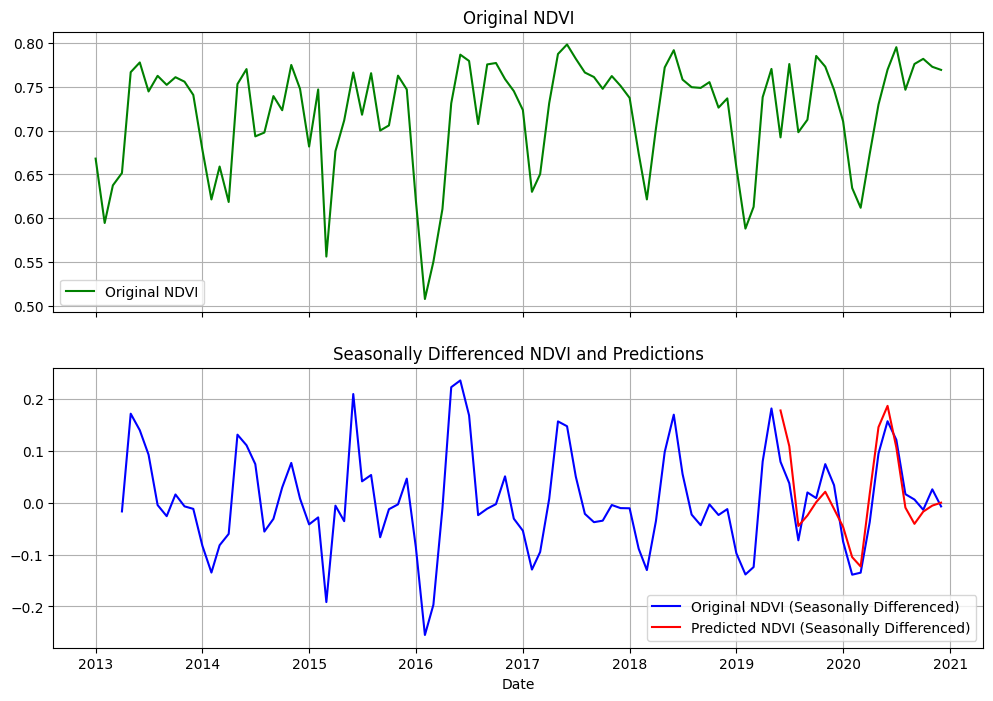

In [ ]:
# Graficar las series en diferentes subplots para mayor claridad
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Gráfico del NDVI original
ax[0].plot(df.index, df['ndvi'], label='Original NDVI', color='green')
ax[0].set_title('Original NDVI')
ax[0].legend()
ax[0].grid(True)

# Gráfico del NDVI diferenciado estacionalmente y el predicho
ax[1].plot(df['ndvi_seasonal_diff'].index, df['ndvi_seasonal_diff'], label='Original NDVI (Seasonally Differenced)', color='blue')
ax[1].plot(test.index, y_pred, label='Predicted NDVI (Seasonally Differenced)', color='red')
ax[1].set_title('Seasonally Differenced NDVI and Predictions')
ax[1].legend()
ax[1].grid(True)

plt.xlabel('Date')
plt.show()



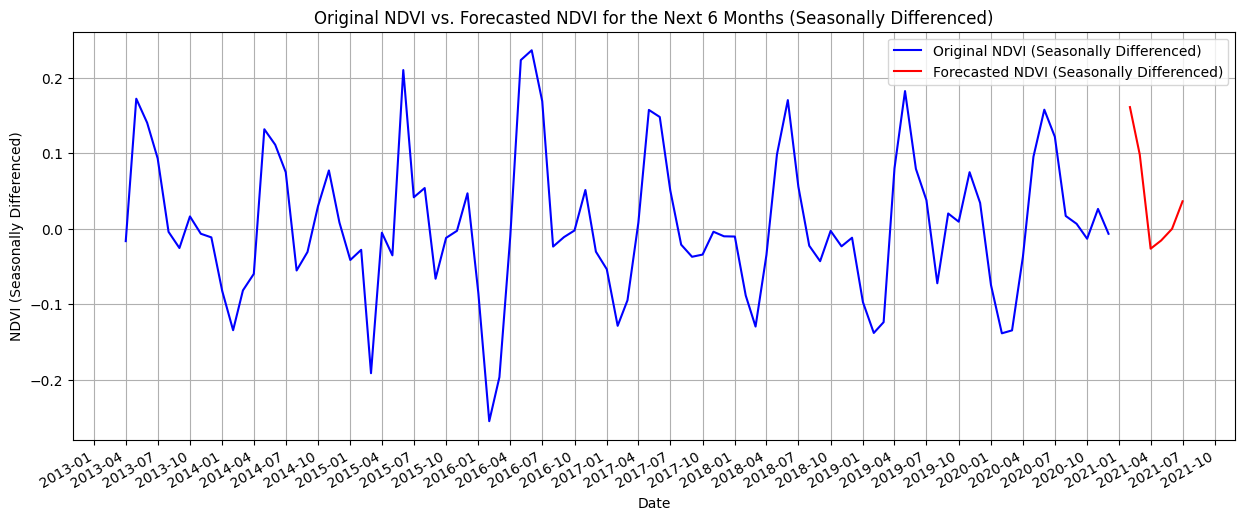

In [ ]:
# Predicciones para los próximos 6 meses
forecast_future = model_fit.forecast(steps=6, exog=exog_train.iloc[-6:])
next_6_months_dates = pd.date_range(start=df.index[-1], periods=7, freq='M')[1:]

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['ndvi_seasonal_diff'], label='Original NDVI (Seasonally Differenced)', color='blue')
plt.plot(next_6_months_dates, forecast_future, label='Forecasted NDVI (Seasonally Differenced)', color='red')
plt.xlabel('Date')
plt.ylabel('NDVI (Seasonally Differenced)')
plt.title('Original NDVI vs. Forecasted NDVI for the Next 6 Months (Seasonally Differenced)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.show()

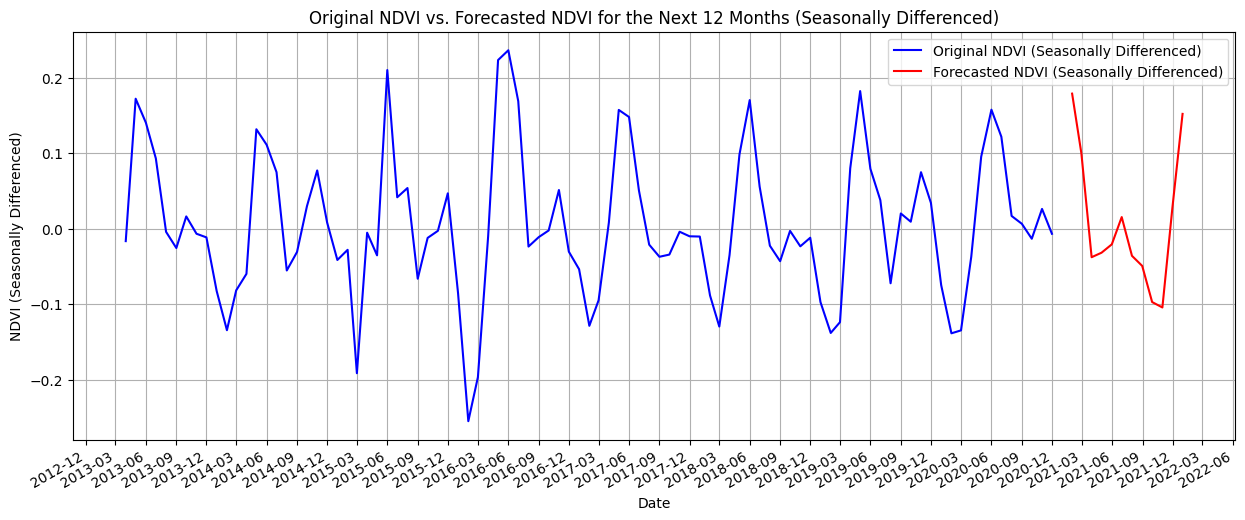

In [ ]:
# Predicciones para los próximos 12 meses
forecast_future = model_fit.forecast(steps=12, exog=exog_train.iloc[-12:])
next_12_months_dates = pd.date_range(start=df.index[-1], periods=13, freq='M')[1:]

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['ndvi_seasonal_diff'], label='Original NDVI (Seasonally Differenced)', color='blue')
plt.plot(next_12_months_dates, forecast_future, label='Forecasted NDVI (Seasonally Differenced)', color='red')
plt.xlabel('Date')
plt.ylabel('NDVI (Seasonally Differenced)')
plt.title('Original NDVI vs. Forecasted NDVI for the Next 12 Months (Seasonally Differenced)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.show()

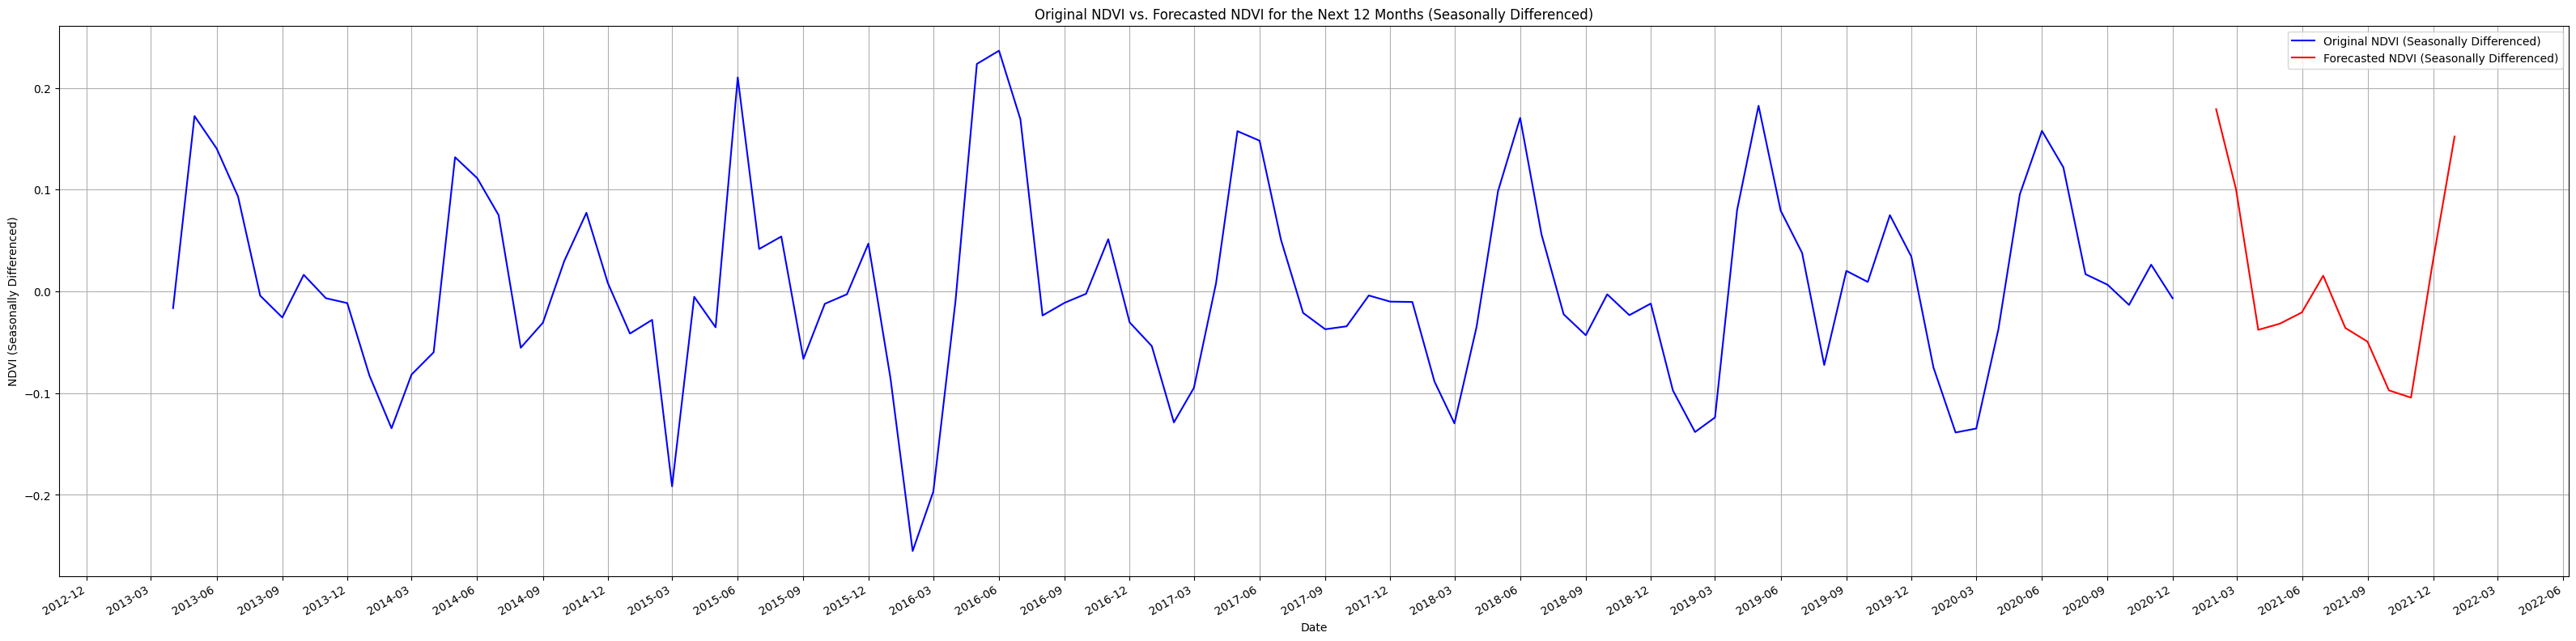

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(df.index, df['ndvi_seasonal_diff'], label='Original NDVI (Seasonally Differenced)', color='blue')
plt.plot(next_12_months_dates, forecast_future, label='Forecasted NDVI (Seasonally Differenced)', color='red')
plt.xlabel('Date')
plt.ylabel('NDVI (Seasonally Differenced)')
plt.title('Original NDVI vs. Forecasted NDVI for the Next 12 Months (Seasonally Differenced)')
plt.legend()
plt.gca().xaxis.set_major_locator(MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()